In [1]:
import numpy as np
import pandas as pd
import mne
import glob
import os
from scipy.signal import resample
from matplotlib import pyplot as plt
from idun_sdk import do_bandpass, prepare_fft
from data_labeler import calculate_bad_epochs
from scipy.signal import find_peaks
import copy
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from utils.lag_calculator import calculate_lag, epoch_data, remove_outliers, replace_outliers,calculate_epochs_lag

### Variables

In [2]:
FILTER_RANGE = [20,40]
BASE_SAMPLE_RATE = 250

FIRST_LAG_EPOCH_SIZE = BASE_SAMPLE_RATE * 60
SECOND_LAG_EPOCH_SIZE = BASE_SAMPLE_RATE * 30 # 30 works best
TOTAL_LINEAR_SEGMENTS = 200

### Upload data

In [3]:
edf_file_path = glob.glob(os.path.join("data", '*.edf'))[0]
csv_file_path = glob.glob(os.path.join("data", '*.csv'))[0]

prodigy_raw_data = mne.io.read_raw_edf(edf_file_path, preload=True)

# upload csv file using numpy
idun_raw_data = np.genfromtxt(csv_file_path, delimiter=',', skip_header=1)

### Unpack prodigy

In [4]:
CHANNEL_1 = "LEFT_EYE"
CHANNEL_2 = "RIGHT_EYE"
PRODIGY_SAMPLE_RATE = 120
prodigy_data, prodigy_times = prodigy_raw_data[:, :]
prodigy_channel_names = prodigy_raw_data.ch_names

# find the position of the channels in channel_names
channel_1_index = prodigy_channel_names.index(CHANNEL_1)
channel_2_index = prodigy_channel_names.index(CHANNEL_2)
# extract the data from the channels
prodigy_channel_1_data = prodigy_data[channel_1_index, :]
prodigy_channel_2_data = prodigy_data[channel_2_index, :]
# minus right eye from left eye
prodigy_channel_1_minus_2 = prodigy_channel_1_data - prodigy_channel_2_data
prodigy_channel_1_minus_2 = prodigy_channel_1_minus_2*1000000

# Upsample to 250 Hz
num_samples_250 = int(BASE_SAMPLE_RATE/PRODIGY_SAMPLE_RATE*len(prodigy_channel_1_minus_2))
resampled_prodigy_data = resample(prodigy_channel_1_minus_2, num_samples_250)

# Filter
prodigy_filtered_data_rs = do_bandpass(resampled_prodigy_data,  [FILTER_RANGE[0], FILTER_RANGE[1]], BASE_SAMPLE_RATE)
resampled_times = np.linspace(0, len(prodigy_filtered_data_rs)/BASE_SAMPLE_RATE, len(prodigy_filtered_data_rs))

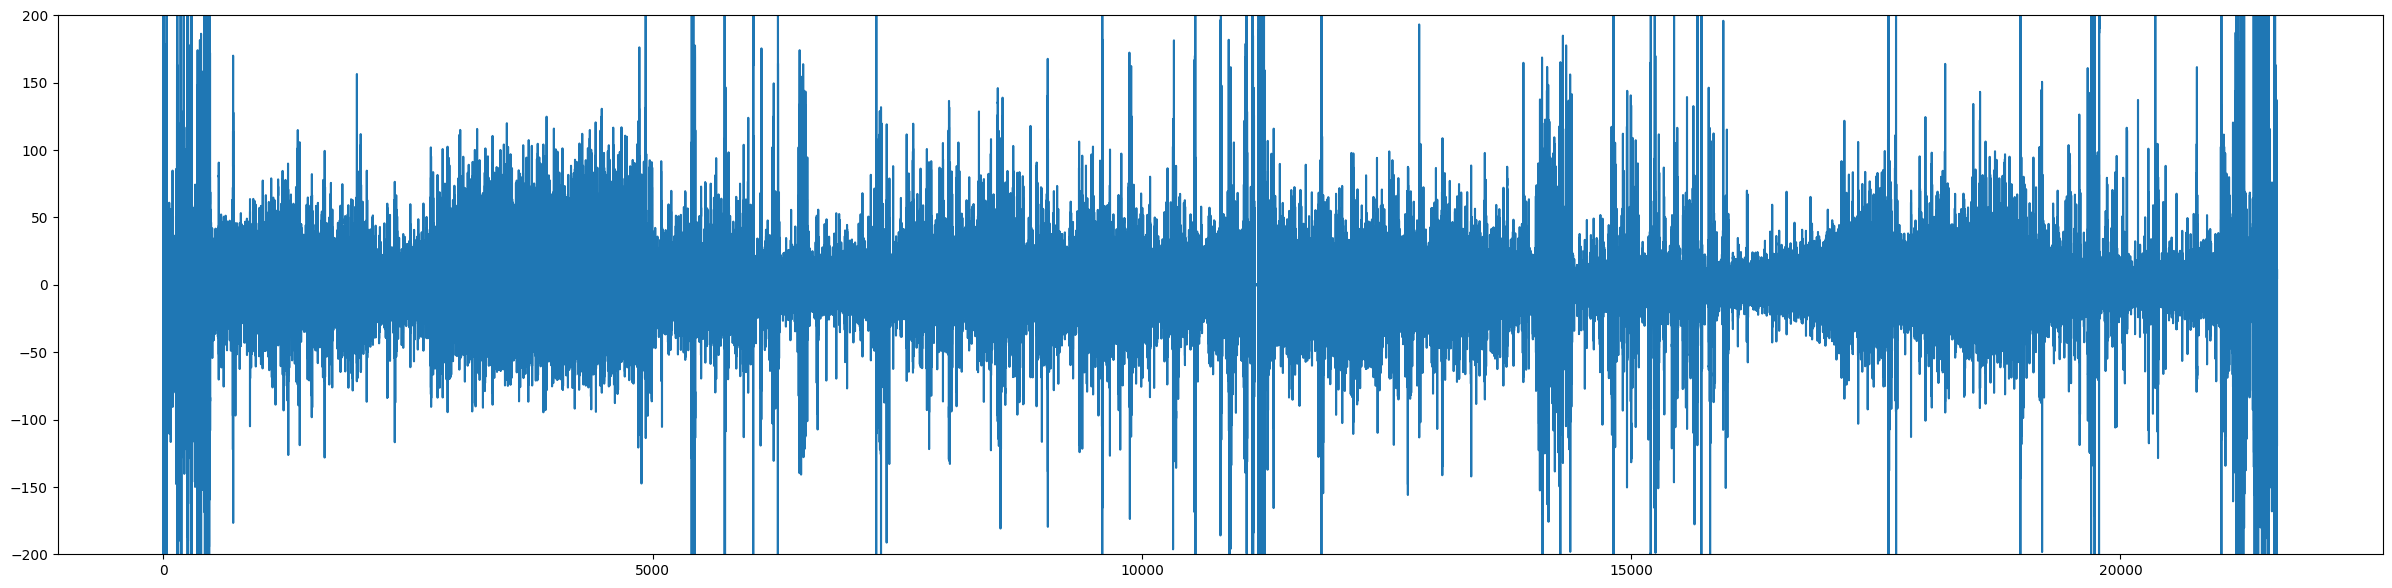

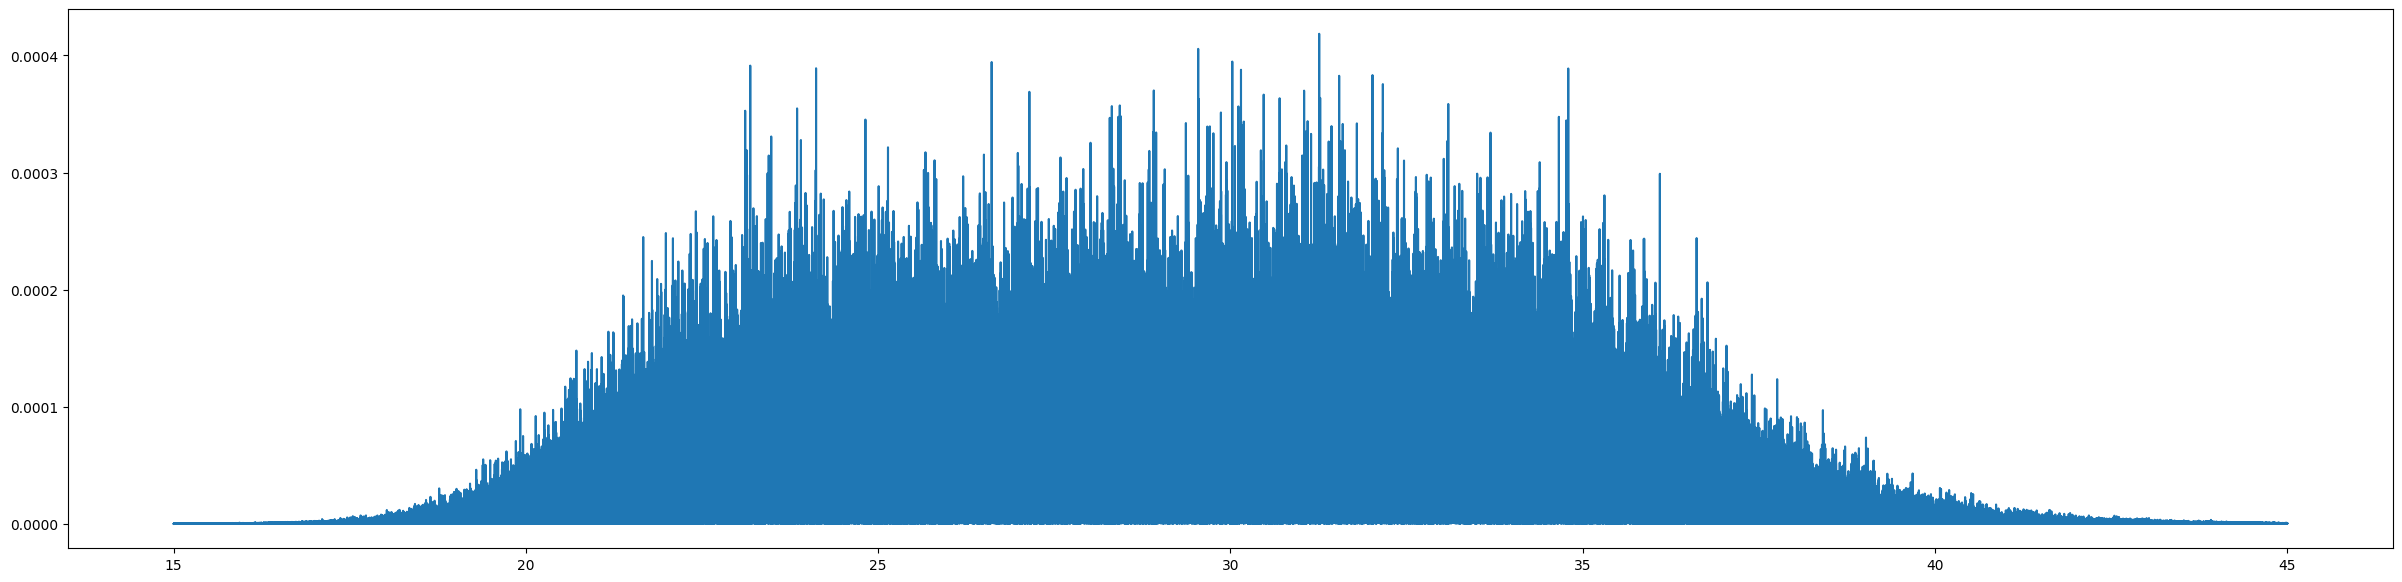

In [5]:
plt.figure(figsize=(30, 7))
plt.plot(resampled_times, resampled_prodigy_data)
plt.ylim(-200, 200)

pr_freqs_rs, pr_fft_rs = prepare_fft(prodigy_filtered_data_rs, FILTER_RANGE[0]-5 ,FILTER_RANGE[1]+5, BASE_SAMPLE_RATE)
plt.figure(figsize=(30, 7))
plt.plot(pr_freqs_rs, pr_fft_rs)

### Unpack IDUN

In [6]:
IDUN_SAMPLE_RATE = 250
idun_data = idun_raw_data[:,1]
idun_time_stamps = idun_raw_data[:,0]
idun_time_stamps = idun_time_stamps - idun_time_stamps[0]

# bandpass filter
idun_filtered_data = do_bandpass(idun_data, [FILTER_RANGE[0], FILTER_RANGE[1]], IDUN_SAMPLE_RATE)


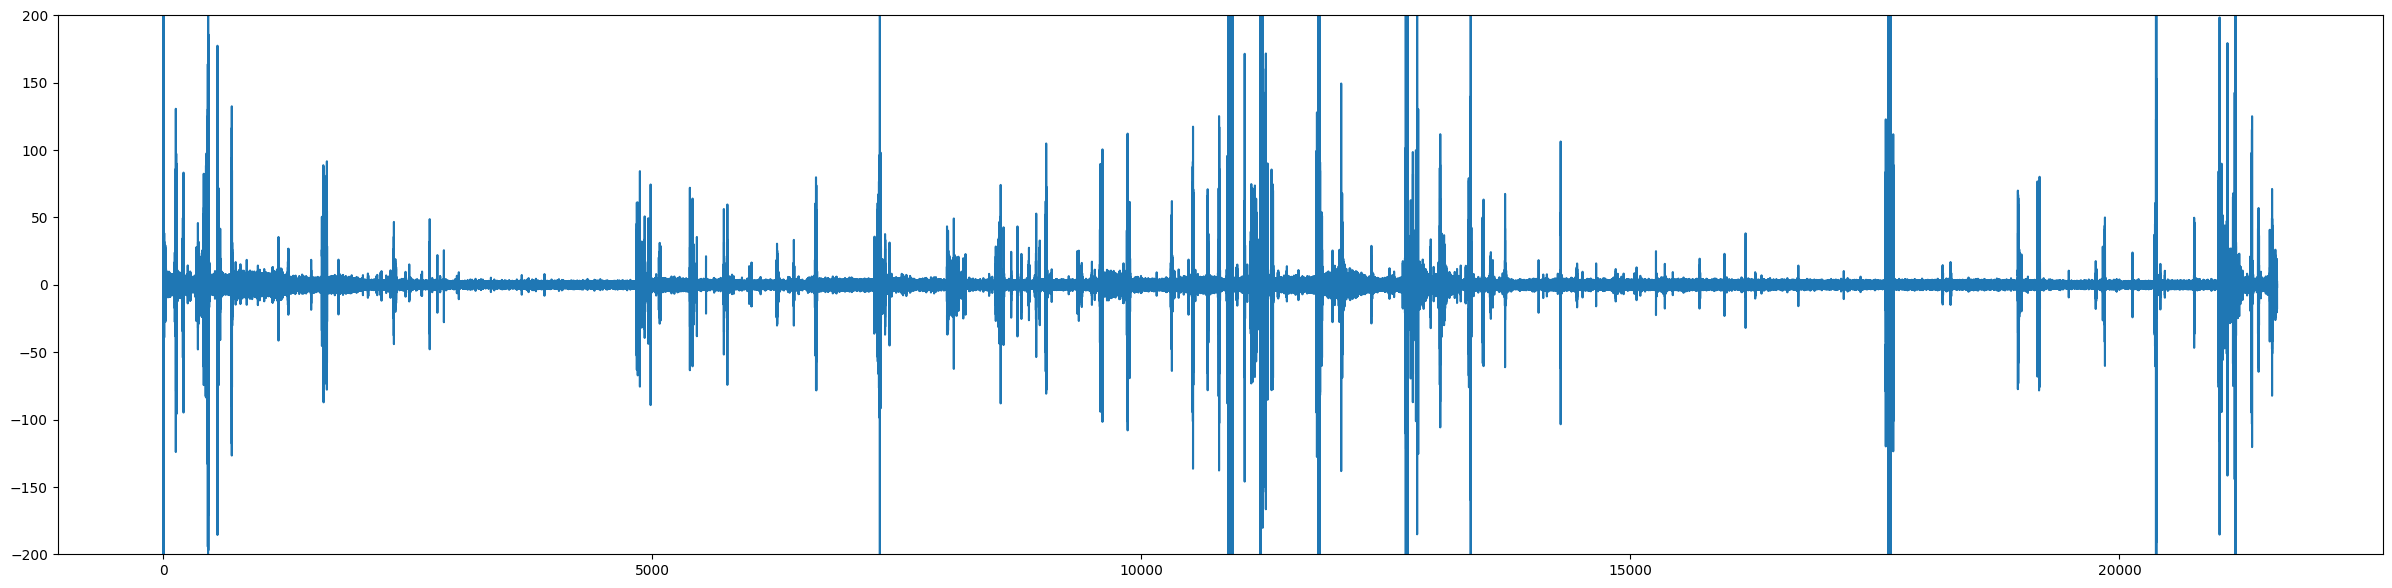

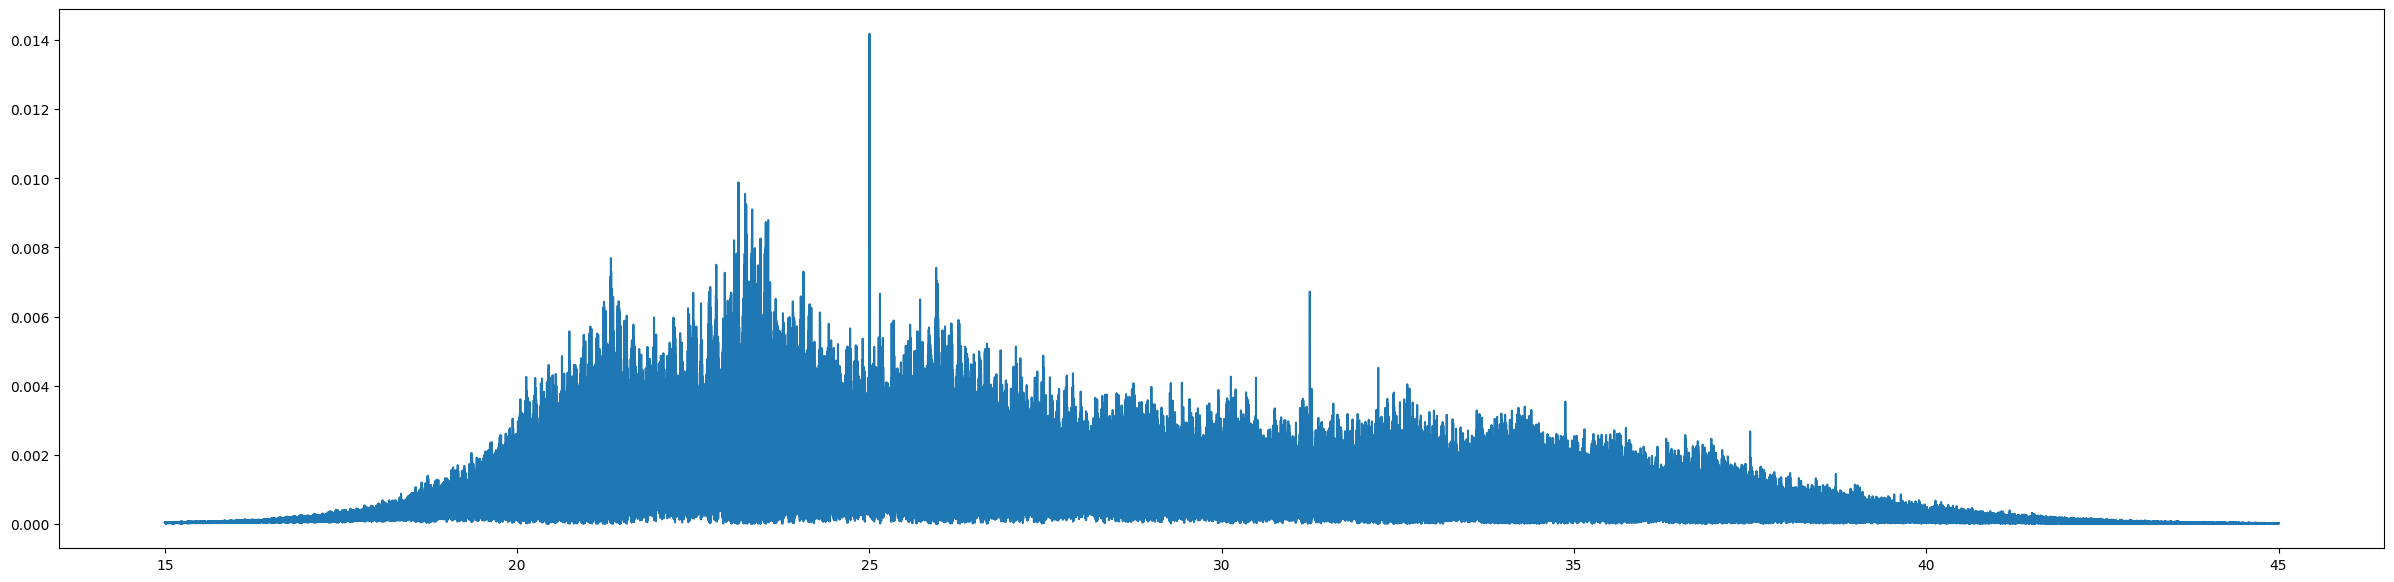

In [7]:
plt.figure(figsize=(30, 7))
plt.plot(idun_time_stamps, idun_filtered_data)
plt.ylim(-200, 200)

id_freqs, id_fft = prepare_fft(idun_filtered_data, FILTER_RANGE[0]-5 ,FILTER_RANGE[1]+5 ,IDUN_SAMPLE_RATE)
plt.figure(figsize=(30, 7))
plt.plot(id_freqs, id_fft)

### Make data same length

In [8]:
prodigy_cleaned_data = prodigy_filtered_data_rs
idun_cleaned_data = idun_filtered_data
# Find which one is longer and how much longer
if len(prodigy_cleaned_data) > len(idun_cleaned_data):
    longer_len = len(prodigy_cleaned_data)
    shorter_len = len(idun_cleaned_data)
    diff = int(longer_len - shorter_len)
    prodigy_cleaned_data = prodigy_cleaned_data[int(diff/2):int(-diff/2)]
else:
    longer_len = len(idun_cleaned_data)
    shorter_len = len(prodigy_cleaned_data)
    diff = int(longer_len - shorter_len)
    idun_cleaned_data = idun_cleaned_data[int(diff/2):int(-diff/2)]
    
same_times = np.linspace(0, len(idun_cleaned_data)/BASE_SAMPLE_RATE, len(idun_cleaned_data))


(-200.0, 200.0)

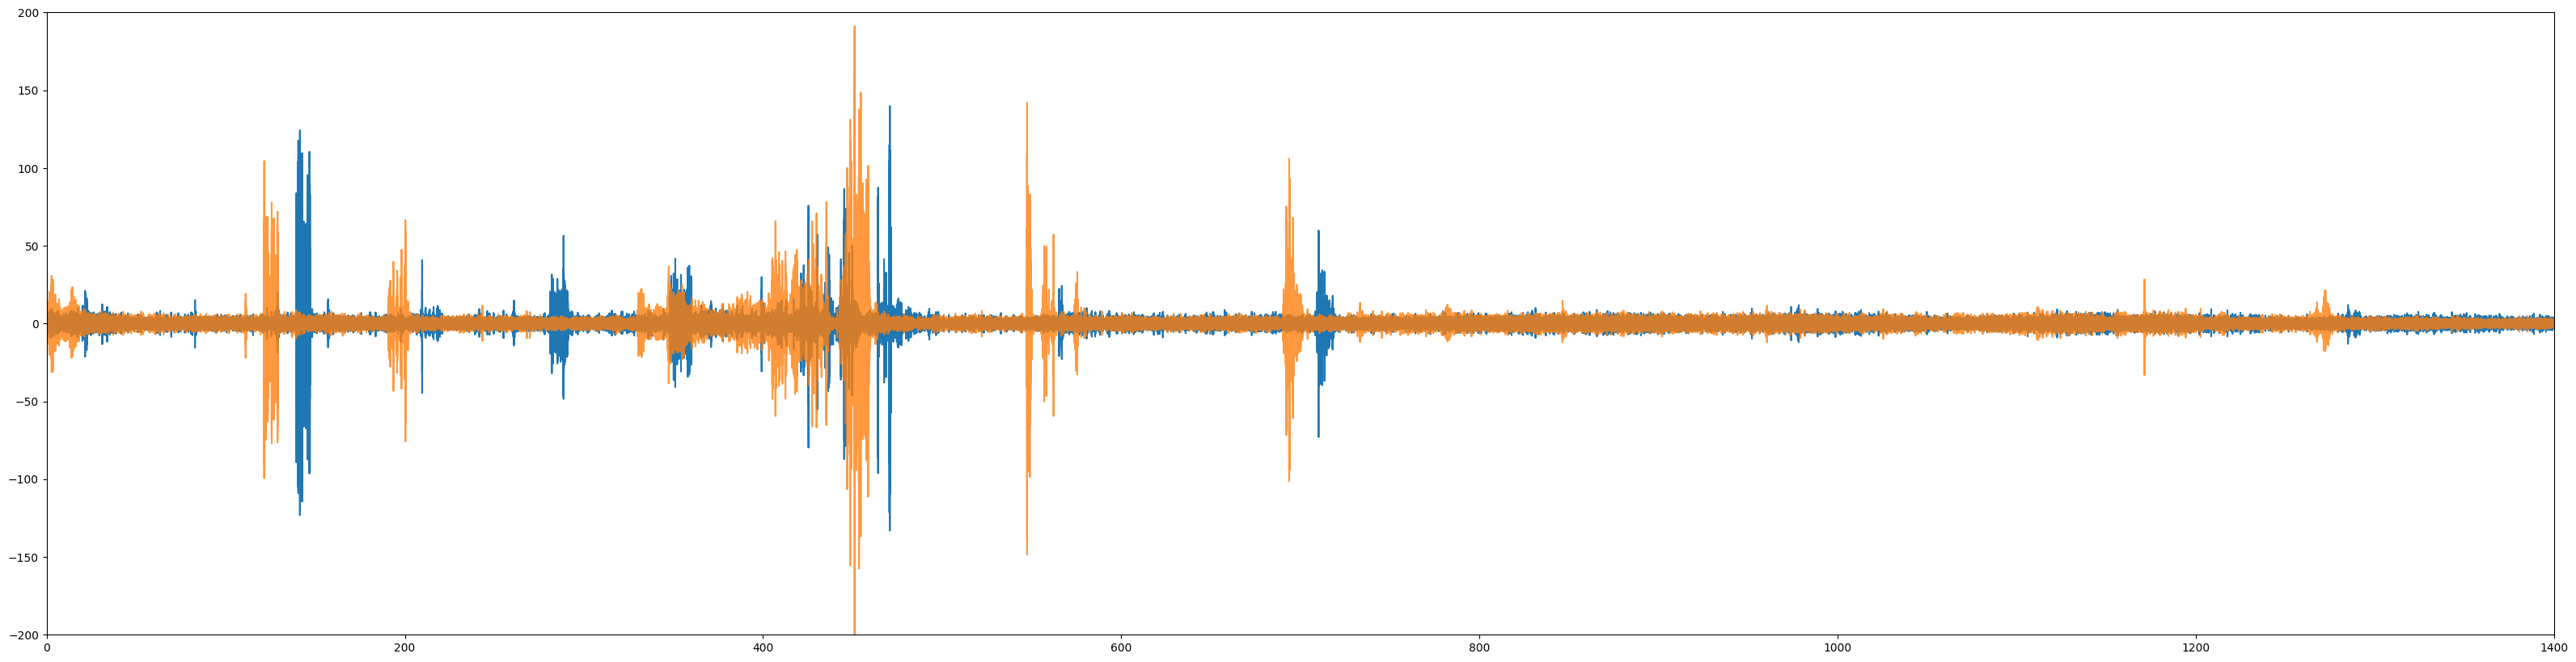

In [9]:
plt.figure(figsize=(40, 10))
plt.plot(same_times, prodigy_cleaned_data)
plt.ylim(-200, 200)
plt.plot(same_times, 0.8*idun_cleaned_data, alpha = 0.8)
plt.xlim(0, 1400)
plt.ylim(-200, 200)

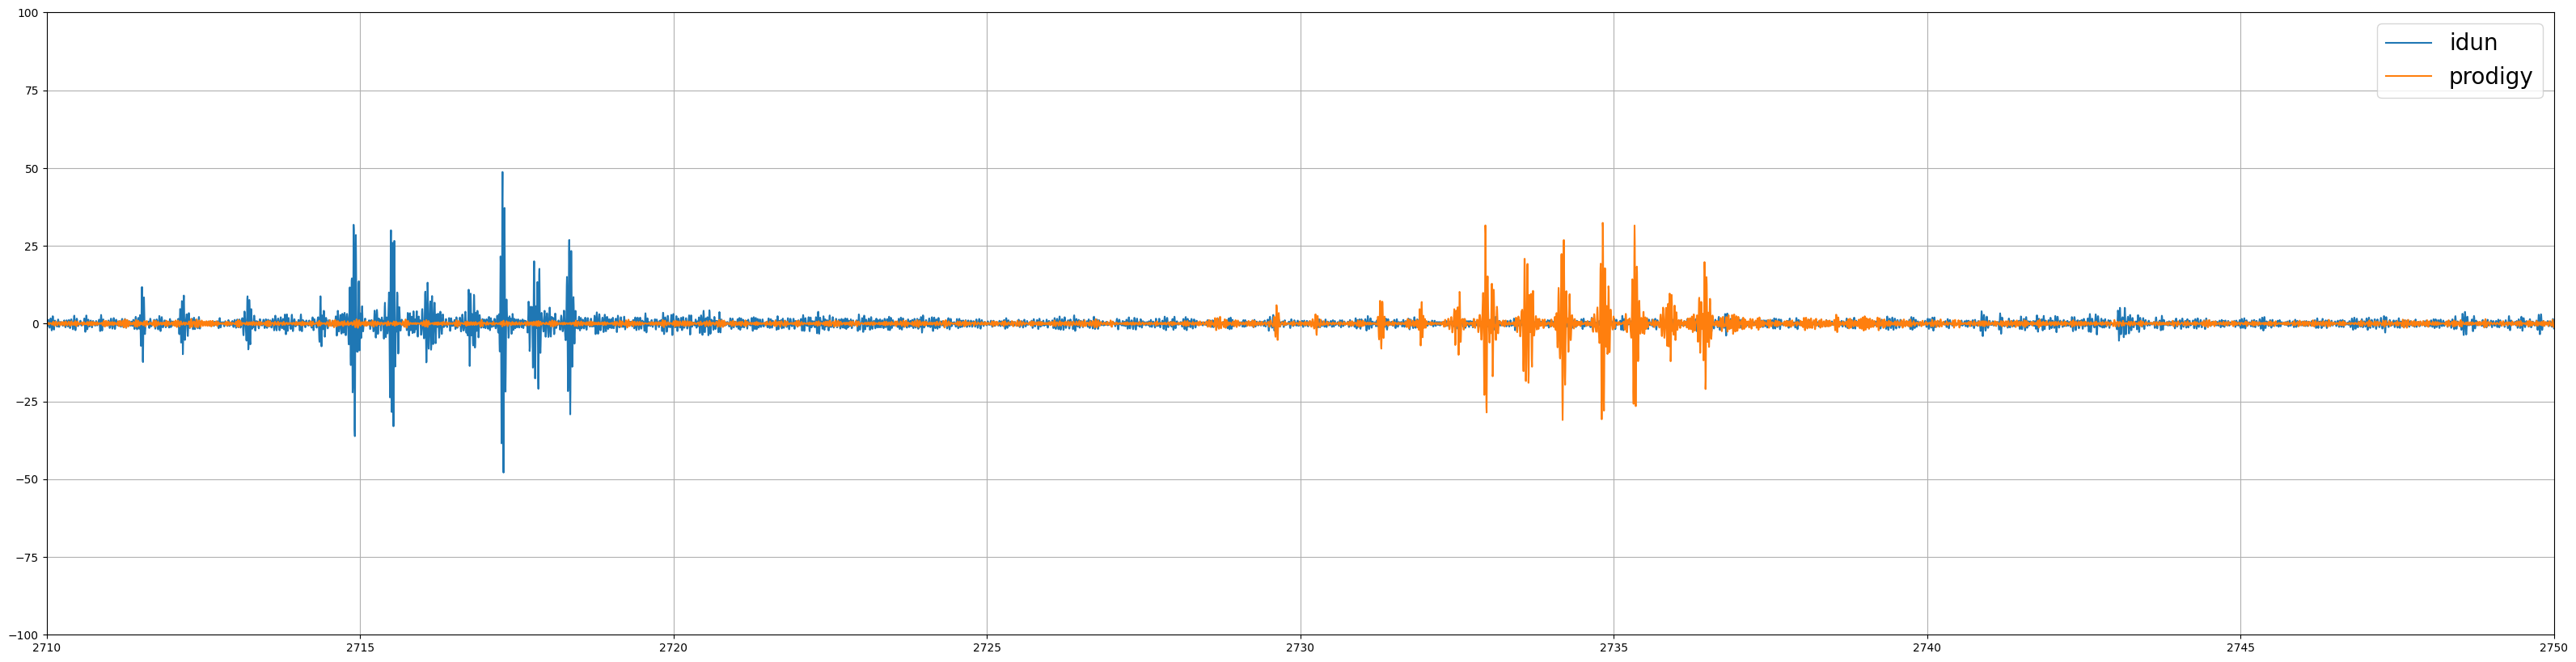

In [10]:
# plot the data
plt.figure(figsize=(40, 10))

plt.plot(same_times,idun_cleaned_data, label='idun')
plt.plot(same_times,0.5*prodigy_cleaned_data, label='prodigy')
plt.xlim(2710, 2750)
plt.legend(fontsize=20)
plt.ylim(-100,100)
plt.grid()

### Calculate lag

In [11]:

prodigy_epochs = epoch_data(prodigy_cleaned_data, FIRST_LAG_EPOCH_SIZE)
idun_epochs = epoch_data(idun_cleaned_data, FIRST_LAG_EPOCH_SIZE)

In [12]:
correlation_arr, max_corr_arr, lag_arr = calculate_epochs_lag(prodigy_epochs, idun_epochs)

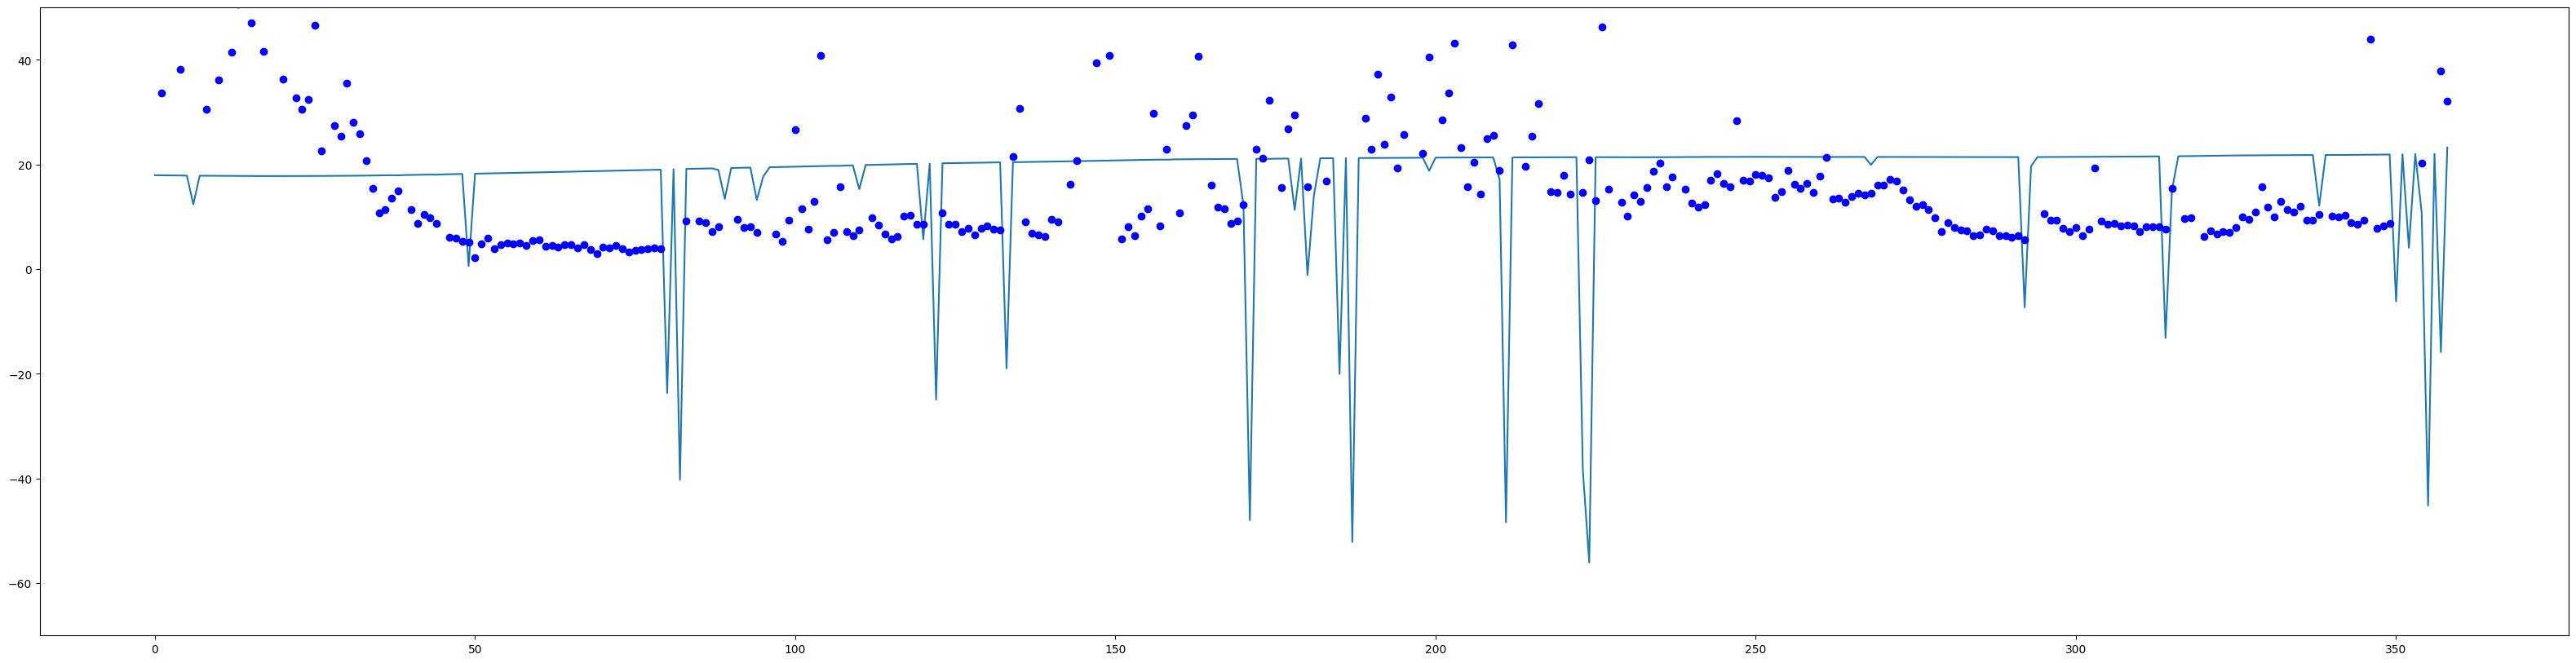

In [13]:
lag_arr_copy = lag_arr[1:].copy()
plt.figure(figsize=(40, 10))
plt.plot(np.array(lag_arr_copy)/250)
plt.plot(np.array(max_corr_arr)/len(lag_arr_copy), 'bo')
plt.ylim(-70,50)
plt.show()

### Cut based on first analysis

lag_mean:  17.96


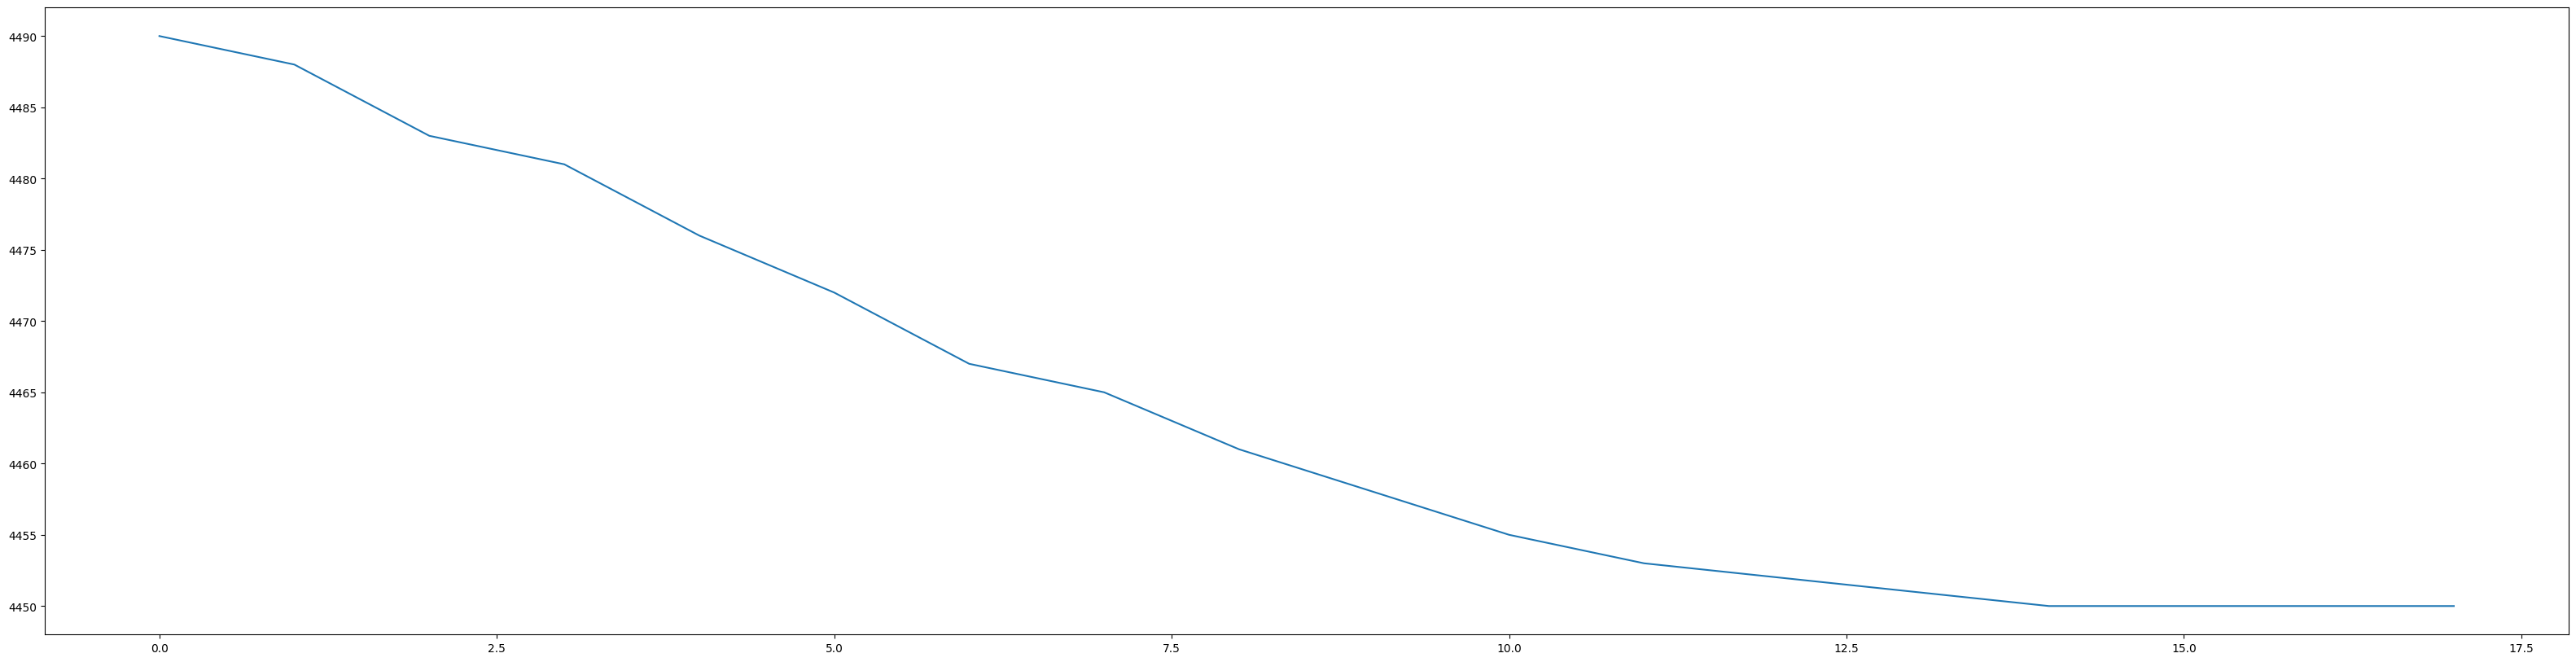

In [14]:
lag_arr = np.array(lag_arr)
lag_initial = lag_arr[:20]
lag_initial = remove_outliers(lag_initial)
lag_mean = lag_initial[0]

# cut the lag_mean data from the start of idun_cleaned_data if it is positive or from the start of prodigy_cleaned_data if negative
if lag_mean < 0:
    idun_cut_data = idun_cleaned_data[lag_mean:]
    prodigy_cut_data = prodigy_cleaned_data[:-(lag_mean)]
else:
    idun_cut_data = idun_cleaned_data[:-(lag_mean)]
    prodigy_cut_data = prodigy_cleaned_data[lag_mean:]

# plot the data
plt.figure(figsize=(40, 10))
# create a  axis
plt.plot(lag_initial, label='idun')

print('lag_mean: ', lag_mean/250)


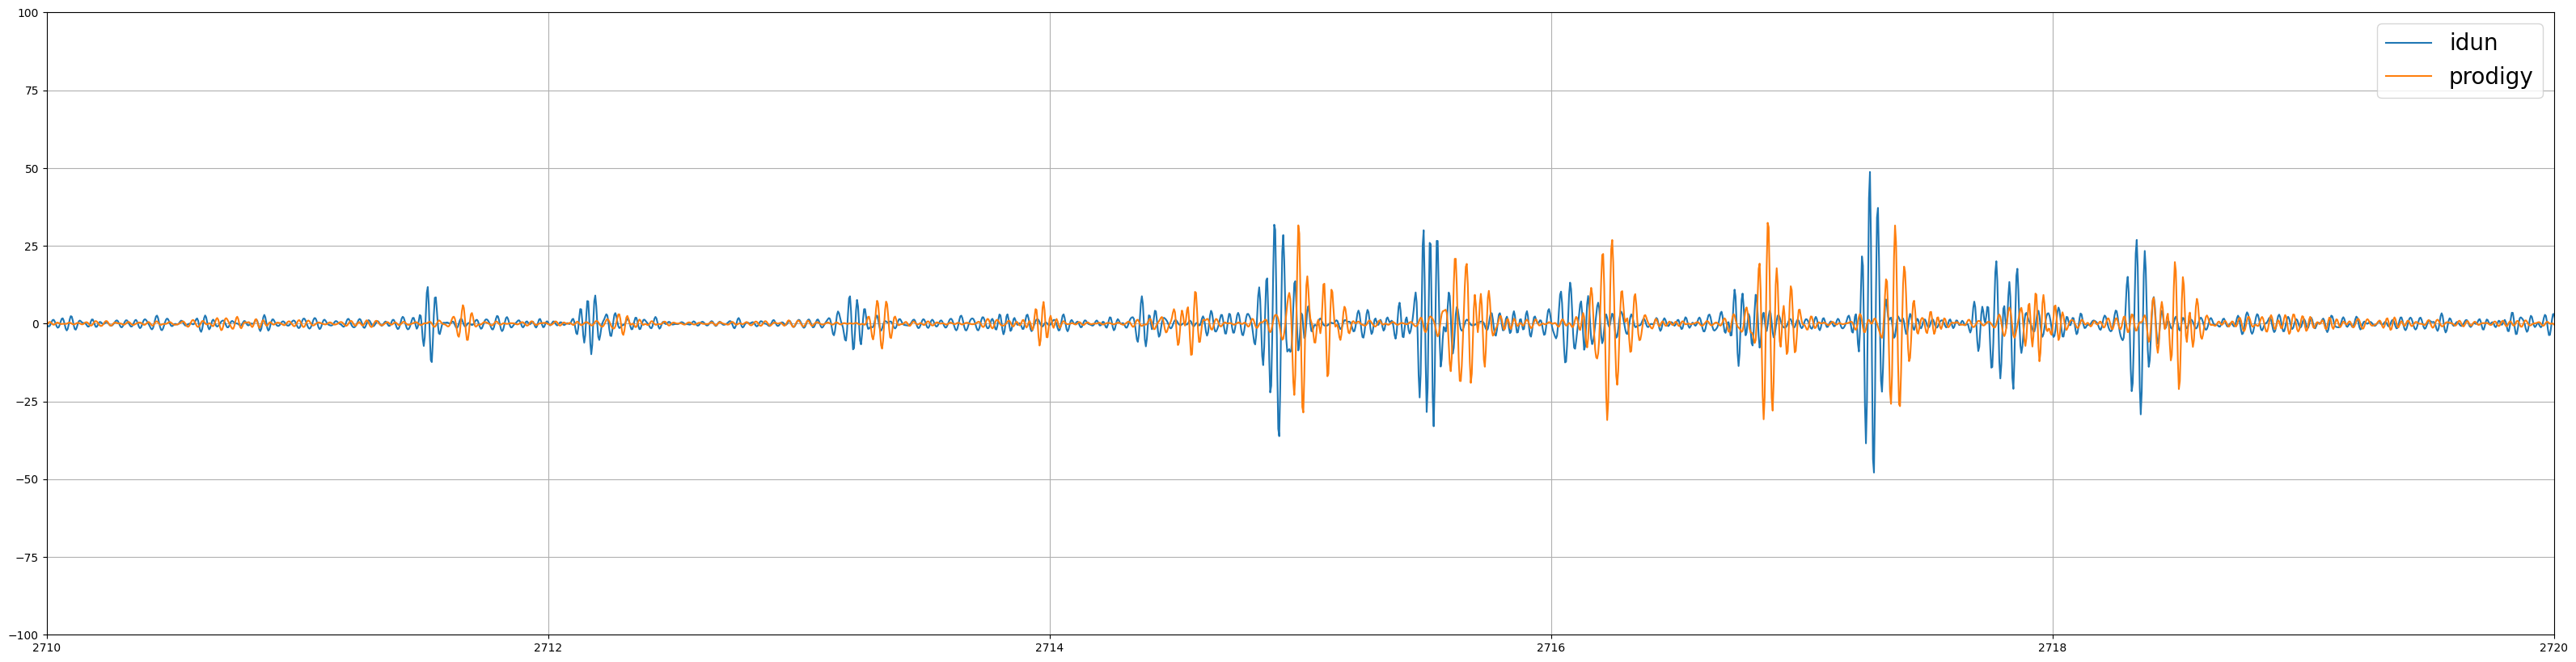

In [15]:
# plot the data
plt.figure(figsize=(40, 10))
# create a seconds axis
time_seconds = np.arange(len(idun_cut_data))/BASE_SAMPLE_RATE
plt.plot(time_seconds,idun_cut_data, label='idun')
plt.plot(time_seconds,0.5*prodigy_cut_data, label='prodigy')
plt.xlim(2710, 2720)
plt.legend(fontsize=20)
plt.ylim(-100,100)
plt.grid()

### Do a more fine grained sync

In [16]:

cutted_prodigy_epochs = epoch_data(prodigy_cut_data, SECOND_LAG_EPOCH_SIZE)
cutted_idun_epochs = epoch_data(idun_cut_data, SECOND_LAG_EPOCH_SIZE)

In [17]:
fine_correlation_arr, fine_max_corr_arr, fine_lag_arr = calculate_epochs_lag(cutted_prodigy_epochs, cutted_idun_epochs)

(-1.0, 5.0)

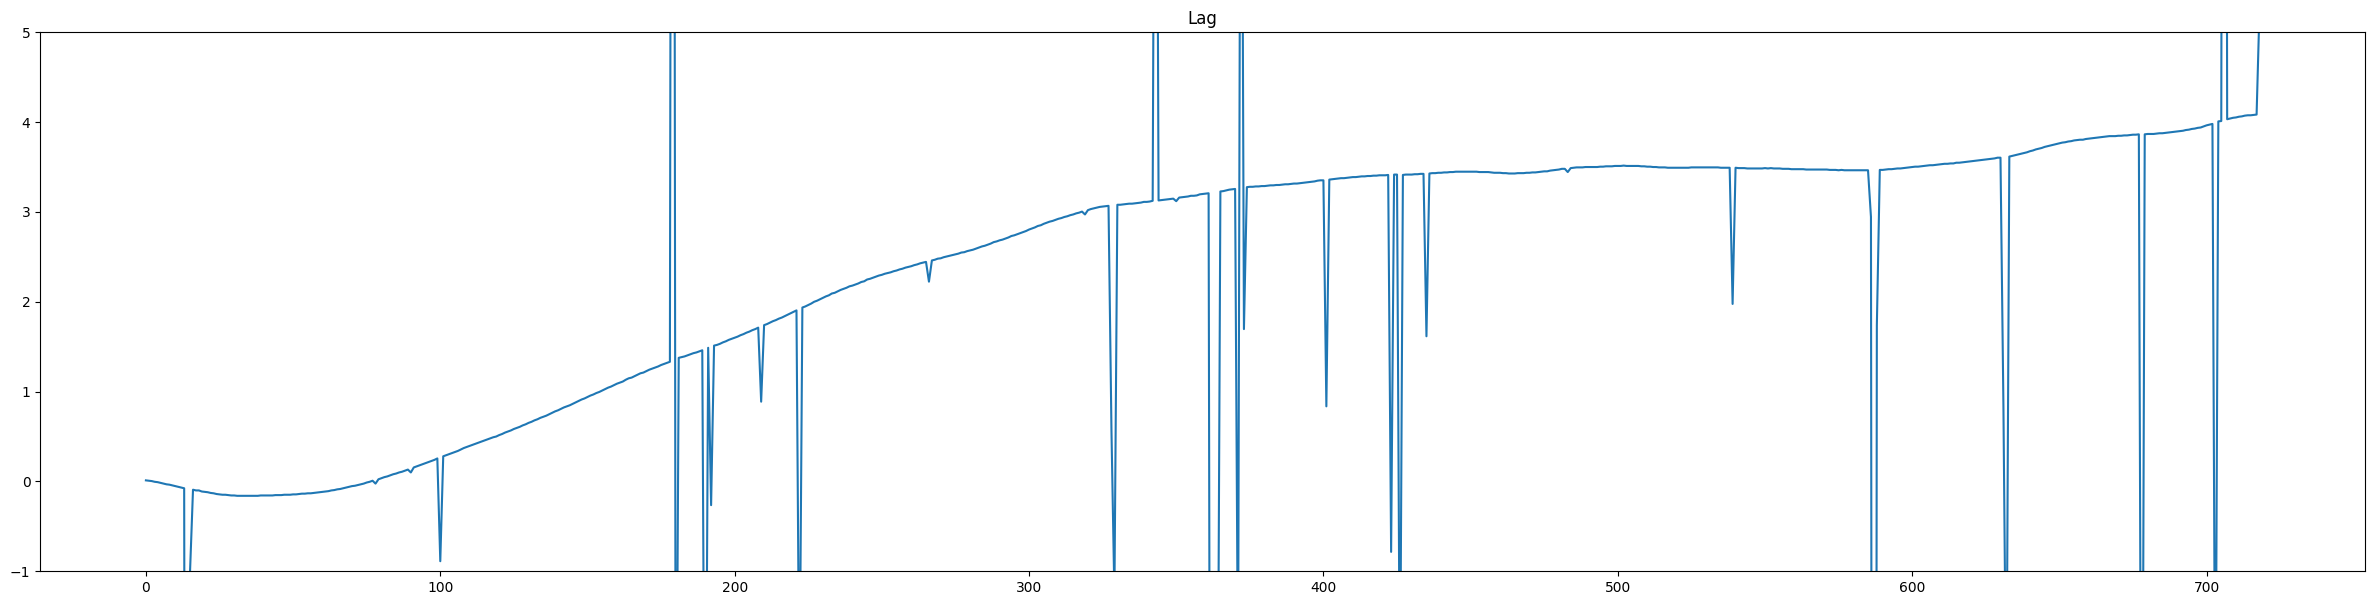

In [18]:
fine_lag_arr_copy = fine_lag_arr.copy()
plt.figure(figsize=(30, 7))
plt.plot(np.array(fine_lag_arr_copy)/250)
plt.title('Lag')
plt.ylim(-1,5)

### Do some cleaning

719

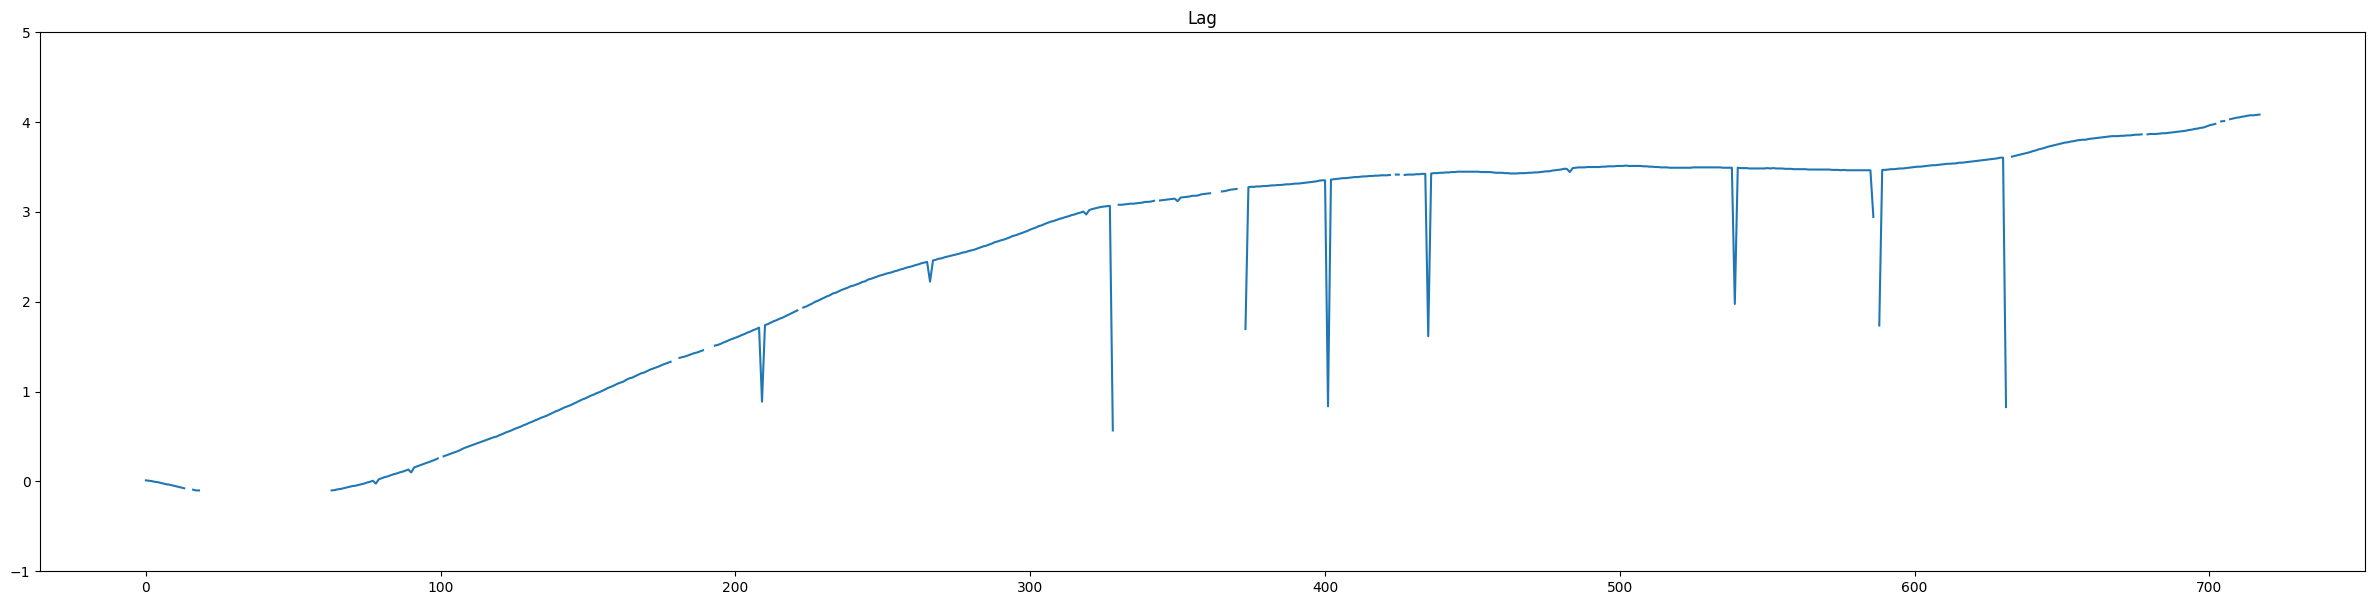

In [19]:
cleaned_fine_lag_arr = replace_outliers(fine_lag_arr_copy)
# Assuming the above code, we just continue:
plt.figure(figsize=(30, 7))
#plt.plot(np.array(fine_lag_arr_copy)/250)
plt.plot(np.array(cleaned_fine_lag_arr)/250)
plt.title('Lag')
plt.ylim(-1,5)
len(cleaned_fine_lag_arr)


### Fit a curve to the data

In [20]:

original_raw_lag = copy.deepcopy(cleaned_fine_lag_arr)
X = np.arange(len(cleaned_fine_lag_arr)).reshape(-1, 1)
X_copy = X.copy()
# find where y is not nan
not_nan_idx = np.where(~np.isnan(original_raw_lag))[0]
original_raw_lag = original_raw_lag[not_nan_idx]
X = X[not_nan_idx]

# Transform the features to 2nd degree polynomial features
poly = PolynomialFeatures(degree=5)
X_poly = poly.fit_transform(X)
# Create a LinearRegression model and fit it to the polynomial features
reg = LinearRegression().fit(X_poly, original_raw_lag)
# Predict values
X_new_poly = poly.transform(X_copy)
linear_regression_lag = reg.predict(X_new_poly)


In [21]:
len(linear_regression_lag)

719

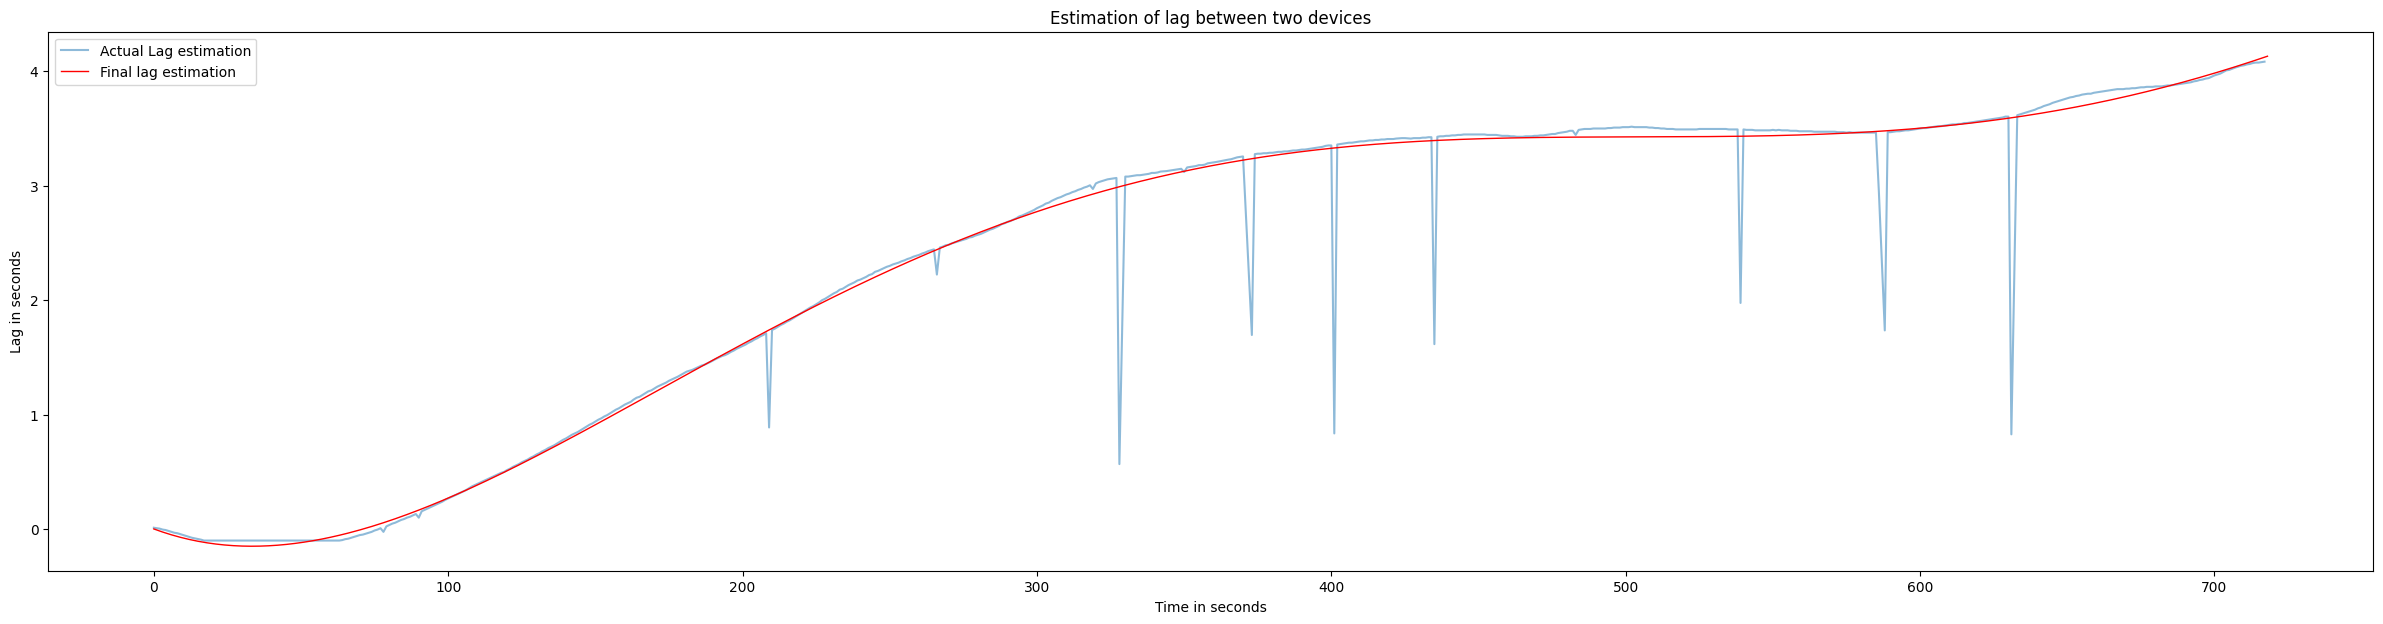

In [22]:
# Plotting the regression curve
plt.figure(figsize=(30, 7))
plt.plot(X, original_raw_lag/250, label='Actual Lag estimation', alpha=0.5)
plt.plot(X_copy, linear_regression_lag/250, "r-", label="Final lag estimation", linewidth=1)
plt.title("Estimation of lag between two devices")
plt.xlabel("Time in seconds")
plt.ylabel("Lag in seconds")
plt.legend()
plt.show()

In [23]:
x = np.linspace(0, len(linear_regression_lag)-1, len(linear_regression_lag))  # This will be 0 to 718
# Approximate with N linear segments
x_knots = np.linspace(0, len(linear_regression_lag)-1, TOTAL_LINEAR_SEGMENTS+1)
y_knots = linear_regression_lag[(x_knots).astype(int)]  # Directly get the y-values from y_pred

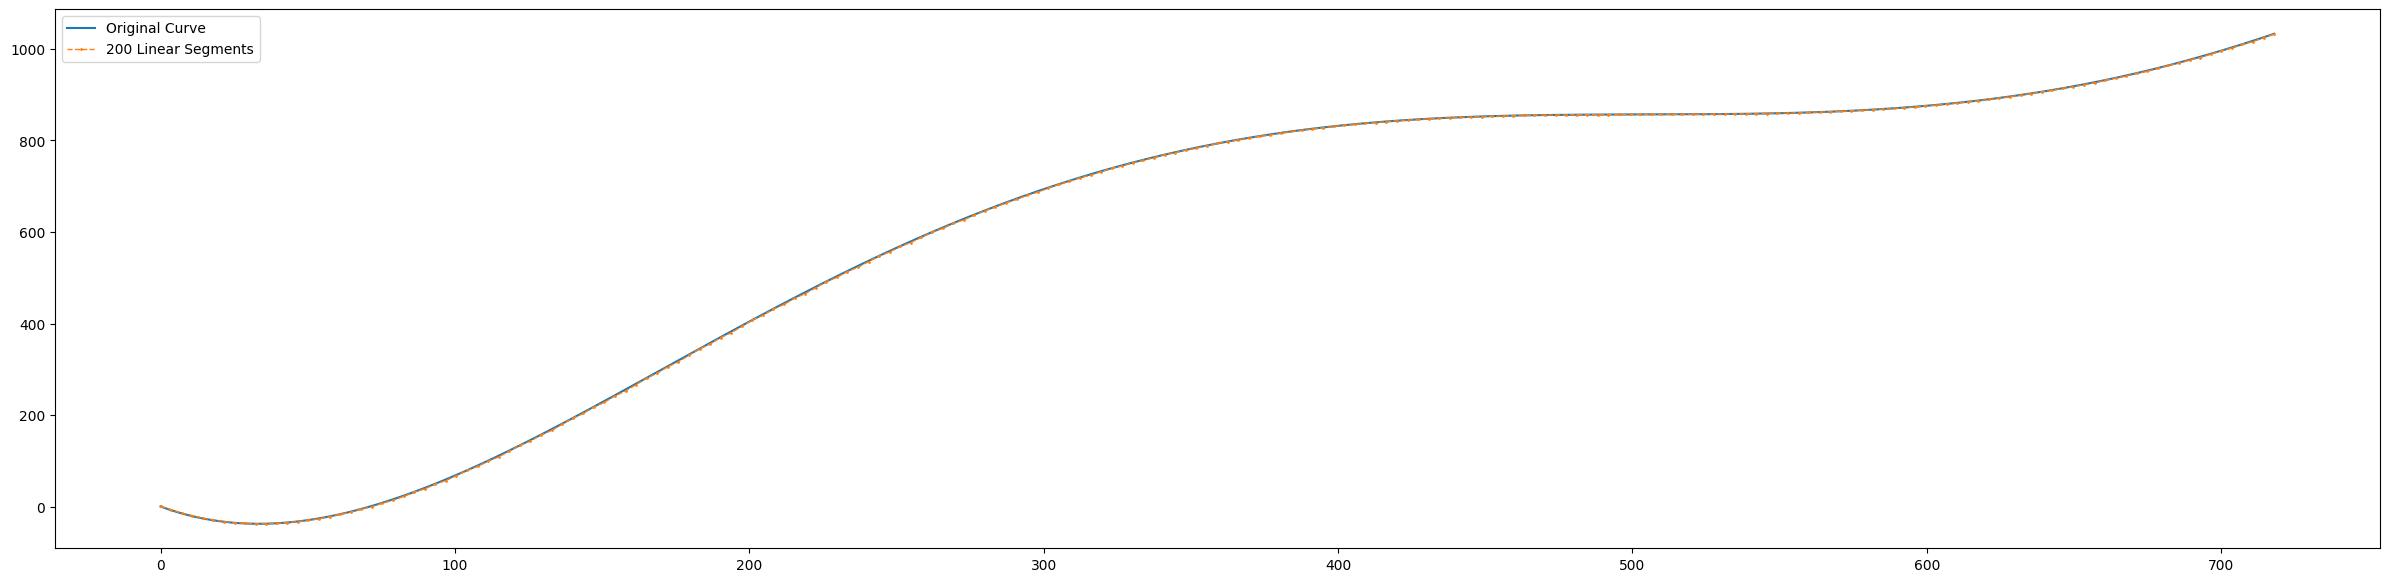

In [24]:
# Plot
plt.figure(figsize=(30, 7))
plt.plot(x, linear_regression_lag, label='Original Curve')
plt.plot(x_knots, y_knots, label=f'{TOTAL_LINEAR_SEGMENTS} Linear Segments', linestyle='--', marker='o', linewidth=1, markersize=1)
plt.legend()
plt.show()

In [25]:
y_knots[0]/250

0.0014862625585647037

### Use the Linear lines to estimate the difference in sampling rates and apply

[   0   -6  -14  -19  -25  -28  -32  -35  -36  -37  -37  -36  -34  -32
  -29  -26  -21  -16  -11   -5    0    7   13   22   31   39   49   57
   67   79   87   99  108  121  133  143  156  166  179  193  203  217
  227  241  252  266  280  291  305  316  330  344  355  369  379  393
  407  417  431  441  455  465  478  491  500  513  523  535  547  556
  568  576  588  599  607  618  626  636  646  654  663  670  680  686
  695  704  710  718  724  731  739  744  751  756  762  768  773  778
  783  788  793  796  801  804  809  812  815  819  822  825  827  830
  833  835  837  839  841  843  844  845  847  848  849  850  851  852
  852  853  854  854  854  855  855  855  856  856  856  856  856  856
  856  856  856  856  856  857  857  857  857  857  858  858  858  859
  859  860  861  861  862  863  864  865  866  868  869  871  873  875
  877  879  881  883  886  889  892  895  898  902  906  909  913  917
  922  925  930  936  940  946  950  957  963  968  975  980  988  995
 1001 

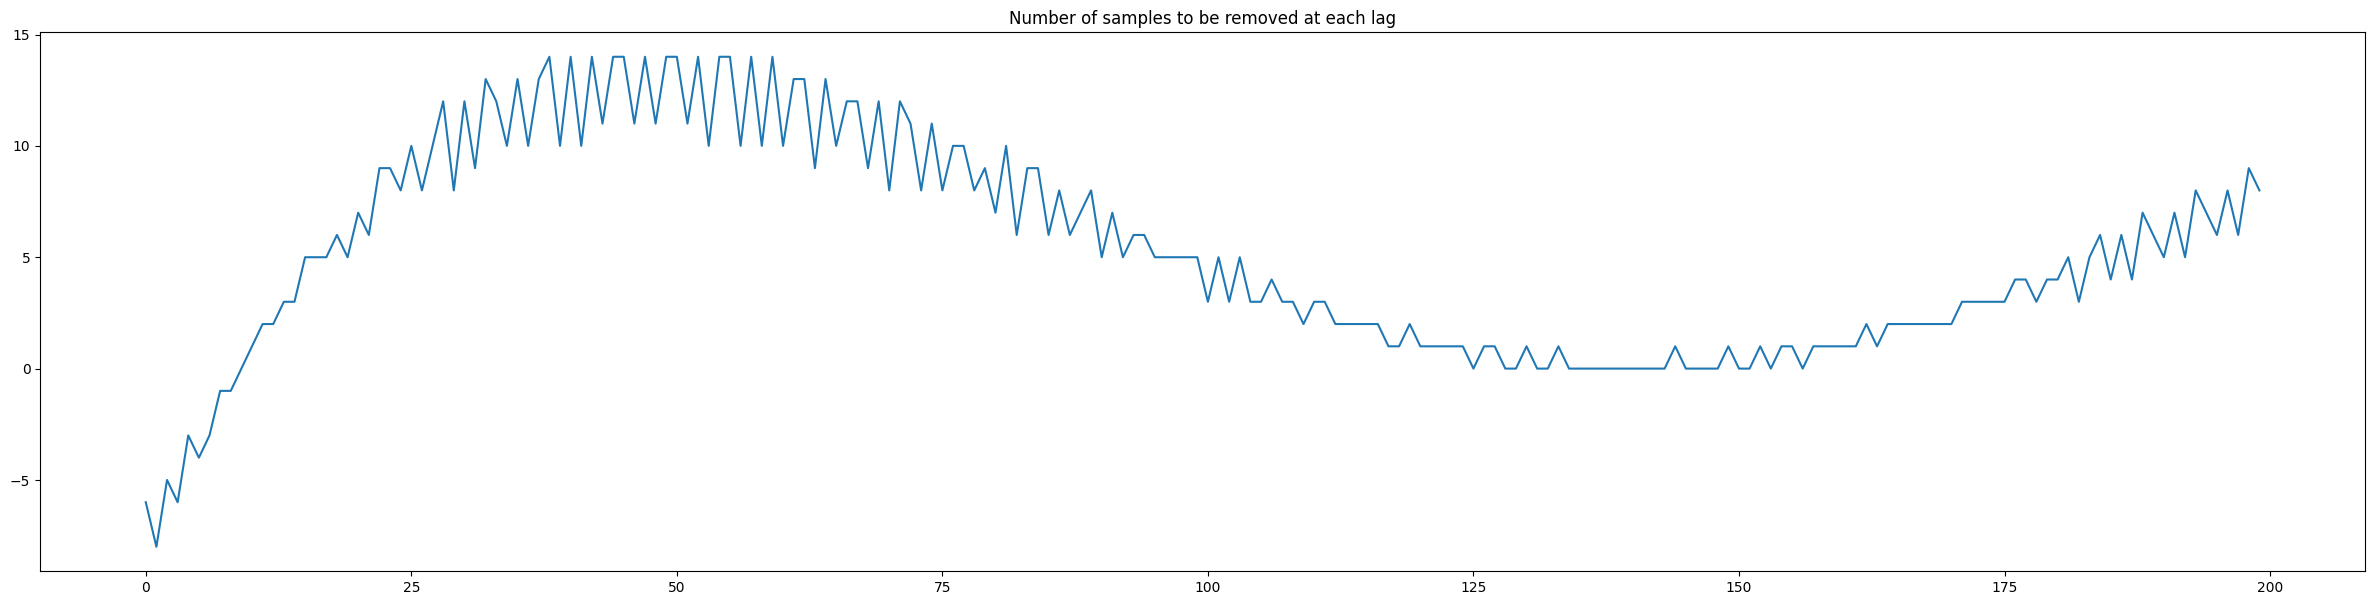

In [26]:
point_size = SECOND_LAG_EPOCH_SIZE
adjustment_epoch_size = int(len(prodigy_cut_data)/TOTAL_LINEAR_SEGMENTS)
lag_positions = np.arange(0, len(prodigy_cut_data), adjustment_epoch_size)
cumulative_lags = y_knots.astype(int)
# amount of sample to be removed at each lag
lag_sizes = np.diff(cumulative_lags)
plt.figure(figsize=(30, 7))
plt.plot(lag_sizes)
plt.title("Number of samples to be removed at each lag")
print(cumulative_lags)

In [27]:
dataset2 = copy.deepcopy(prodigy_cut_data)
dataset2_list = dataset2.tolist()

for i in range(len(lag_positions)):
    start_index = lag_positions[i]
    
    # Calculate how many elements to replace with np.nan
    if i == 0:
        n_replace = int(cumulative_lags[i])
    else:
        n_replace = int(cumulative_lags[i] - cumulative_lags[i-1])
    
    # For debugging
    print(f"Replacing {n_replace} values from position {start_index}.")
    
    for j in range(n_replace):
        if start_index+j < len(dataset2_list):
            dataset2_list[start_index+j] = np.nan

# Convert back to numpy array and remove np.nan values
adjusted_dataset2 = np.array(dataset2_list)
adjusted_dataset2 = adjusted_dataset2[~np.isnan(adjusted_dataset2)]

prodigy_adjusted_final_arr = adjusted_dataset2
idun_adjusted_final_arr = idun_cut_data

# Cut from the end of the longer dataset
if len(prodigy_adjusted_final_arr) > len(idun_cut_data):
    prodigy_adjusted_final_arr = prodigy_adjusted_final_arr[:len(idun_adjusted_final_arr)]
else:
    idun_adjusted_final_arr = idun_adjusted_final_arr[:len(prodigy_adjusted_final_arr)]

print(len(prodigy_adjusted_final_arr), len(idun_adjusted_final_arr))


Replacing 0 values from position 0.
Replacing -6 values from position 26977.
Replacing -8 values from position 53954.
Replacing -5 values from position 80931.
Replacing -6 values from position 107908.
Replacing -3 values from position 134885.
Replacing -4 values from position 161862.
Replacing -3 values from position 188839.
Replacing -1 values from position 215816.
Replacing -1 values from position 242793.
Replacing 0 values from position 269770.
Replacing 1 values from position 296747.
Replacing 2 values from position 323724.
Replacing 2 values from position 350701.
Replacing 3 values from position 377678.
Replacing 3 values from position 404655.
Replacing 5 values from position 431632.
Replacing 5 values from position 458609.
Replacing 5 values from position 485586.
Replacing 6 values from position 512563.
Replacing 5 values from position 539540.
Replacing 7 values from position 566517.
Replacing 6 values from position 593494.
Replacing 9 values from position 620471.
Replacing 9 val

In [28]:
final_prodigy_epochs = epoch_data(prodigy_adjusted_final_arr, SECOND_LAG_EPOCH_SIZE)
final_idun_epochs = epoch_data(idun_adjusted_final_arr, SECOND_LAG_EPOCH_SIZE)

In [29]:
final_correlation_arr, final_max_corr_arr, final_lag_arr = calculate_epochs_lag(final_prodigy_epochs, final_idun_epochs)

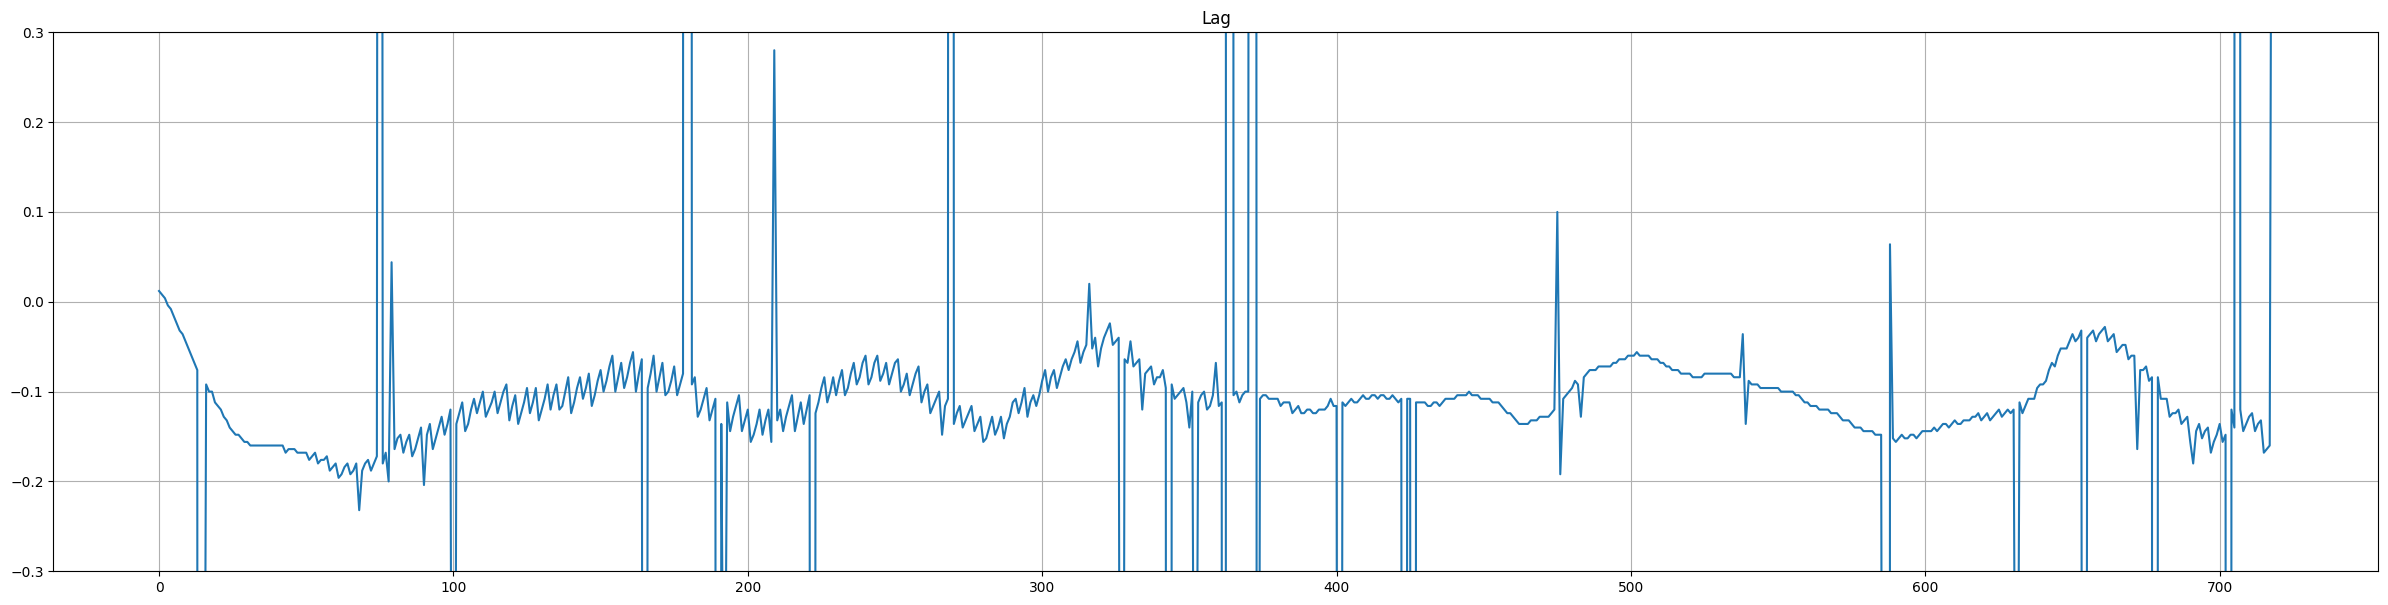

In [ ]:
final_lag_arr_copy = final_lag_arr.copy()
plt.figure(figsize=(30, 7))
plt.plot(np.array(final_lag_arr)/250)
plt.title('Lag')
plt.ylim(-0.3,0.3)
plt.grid()

### Clean the lags

In [ ]:
cleaned_final_lag_arr = replace_outliers(final_lag_arr_copy)
# rfind where the values are nan
nan_idx = np.argwhere(np.isnan(cleaned_final_lag_arr))
# remove the nan values
mean_final_lag = np.mean(np.delete(cleaned_final_lag_arr, nan_idx, axis=0))

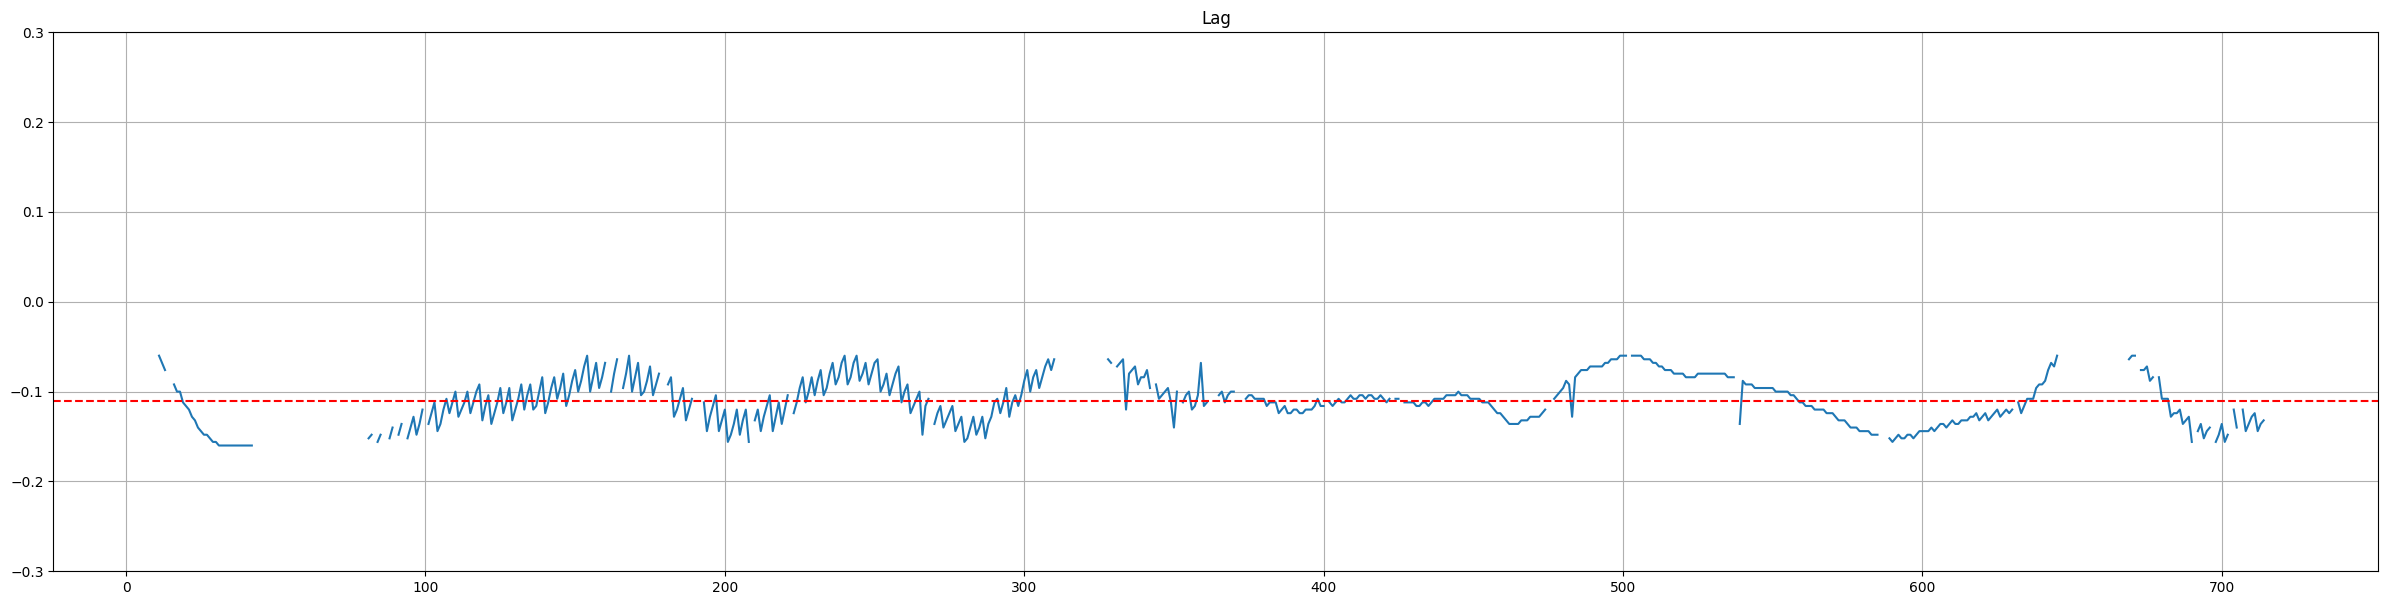

In [ ]:
plt.figure(figsize=(30, 7))
plt.plot(np.array(cleaned_final_lag_arr)/250)
# plot the mean_final_lag as a horizontal line
plt.axhline(y=mean_final_lag/250, color='r', linestyle='--')
plt.title('Lag')
plt.ylim(-0.3,0.3)
plt.grid()

### Remove this final shift

In [ ]:
# remove mean amount from start of idun data if negative else from start of prodigy data if positive
if mean_final_lag > 0:
    shifted_final_prodigy_arr = prodigy_adjusted_final_arr[int(mean_final_lag):]
    shifted_final_idun_arr = idun_adjusted_final_arr[:int(mean_final_lag)]
else:
    shifted_final_prodigy_arr = prodigy_adjusted_final_arr[:-(-int(mean_final_lag))]
    shifted_final_idun_arr = idun_adjusted_final_arr[-int(mean_final_lag):]


In [ ]:
len(shifted_final_prodigy_arr)


5394414

In [ ]:
shifted_final_prodigy_epochs = epoch_data(shifted_final_prodigy_arr, SECOND_LAG_EPOCH_SIZE)
shifted_final_idun_epochs = epoch_data(shifted_final_idun_arr, SECOND_LAG_EPOCH_SIZE)
shifted_final_correlation_arr, shifted_final_max_corr_arr, shifted_final_lag_arr = calculate_epochs_lag(shifted_final_prodigy_epochs, shifted_final_idun_epochs)

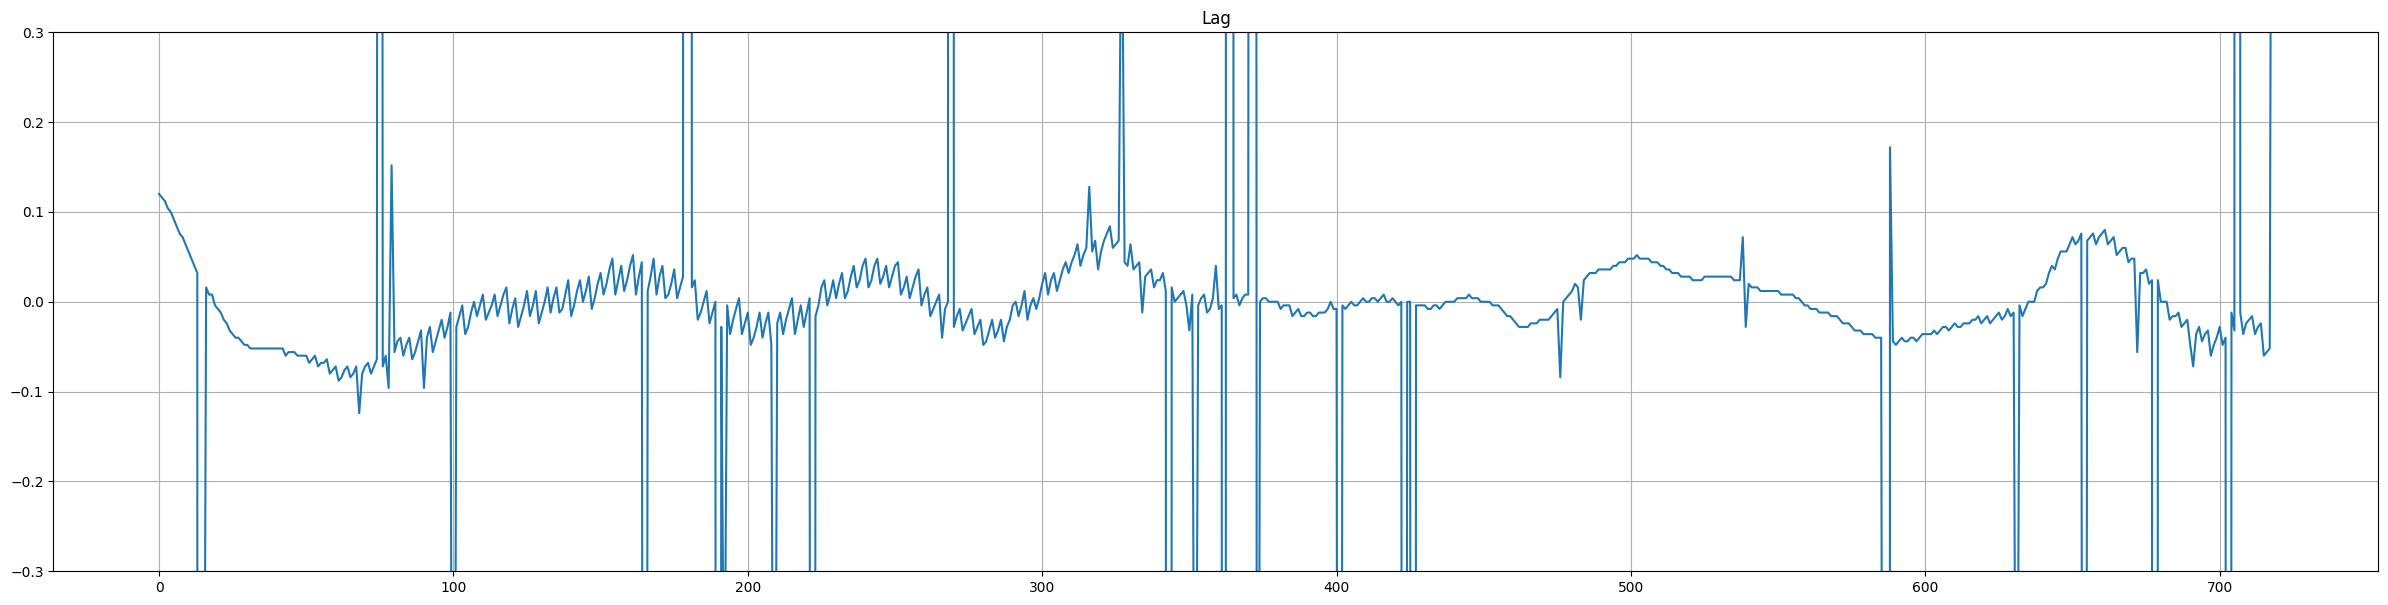

In [ ]:

plt.figure(figsize=(30, 7))
plt.plot(np.array(shifted_final_lag_arr)/250)
plt.title('Lag')
plt.ylim(-0.3,0.3)
plt.grid()

### Plot final data

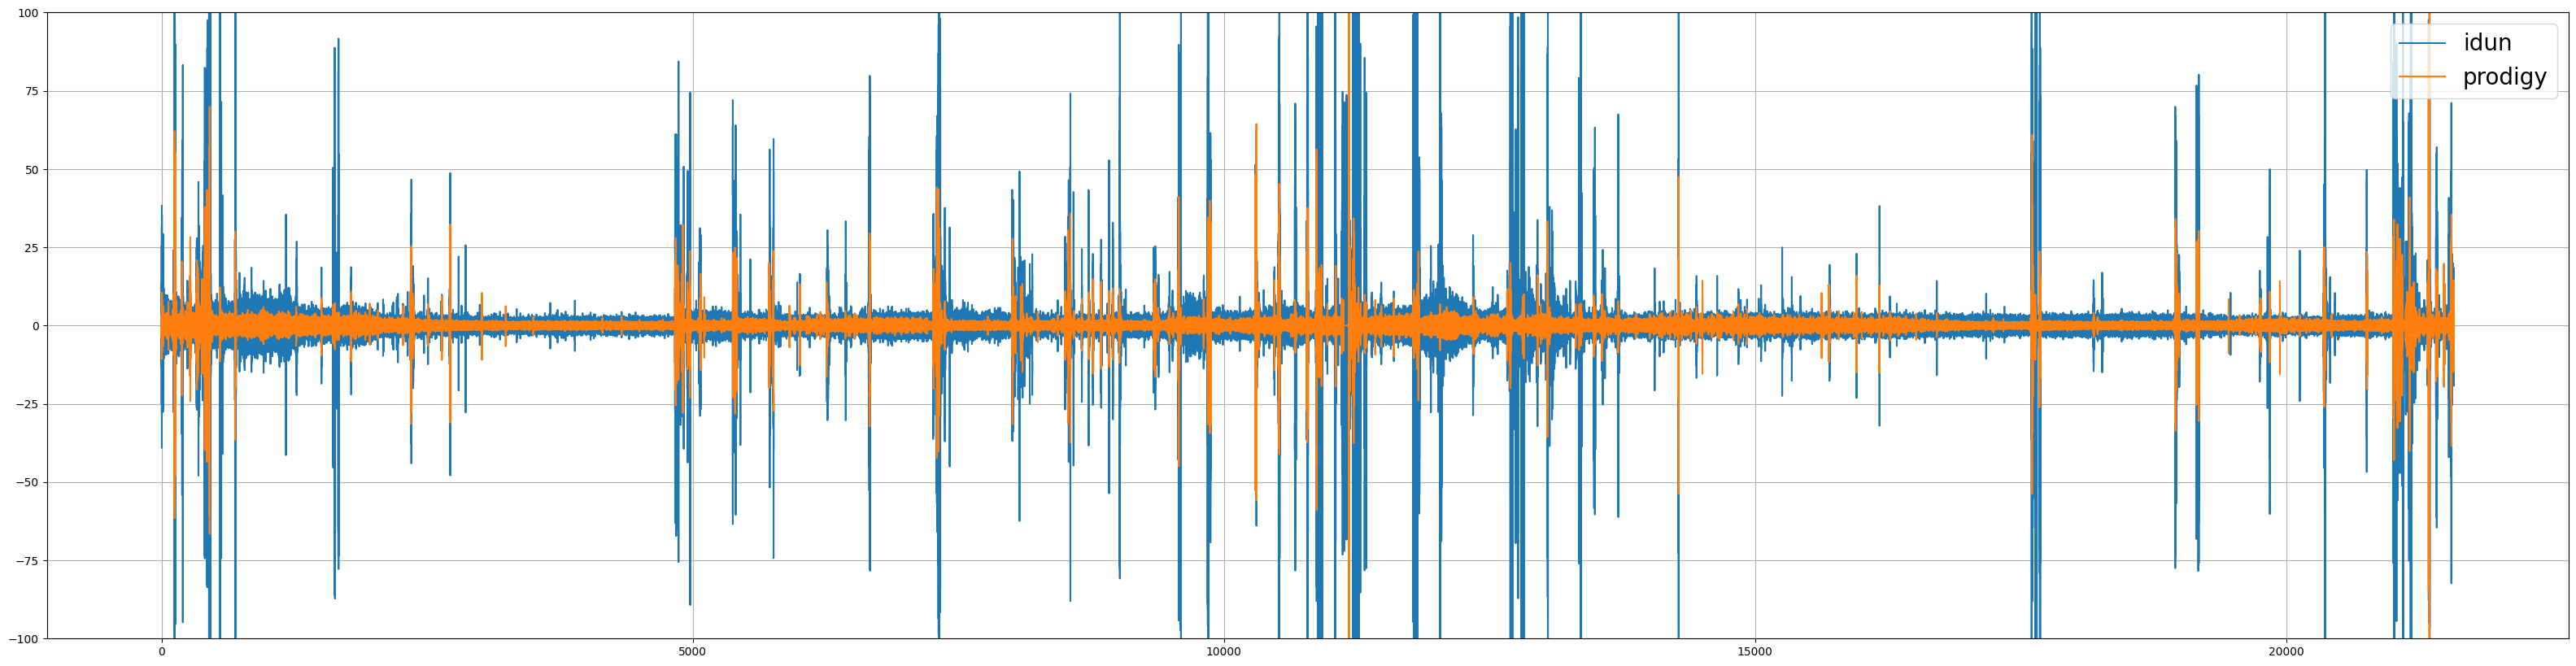

In [ ]:
plt.figure(figsize=(40, 10))
# create a seconds axis
time_seconds = np.arange(len(shifted_final_idun_arr))/BASE_SAMPLE_RATE
plt.plot(time_seconds,shifted_final_idun_arr, label='idun')
plt.plot(time_seconds,0.5*shifted_final_prodigy_arr, label='prodigy')
plt.legend(fontsize=20)
plt.ylim(-100,100)
plt.grid()

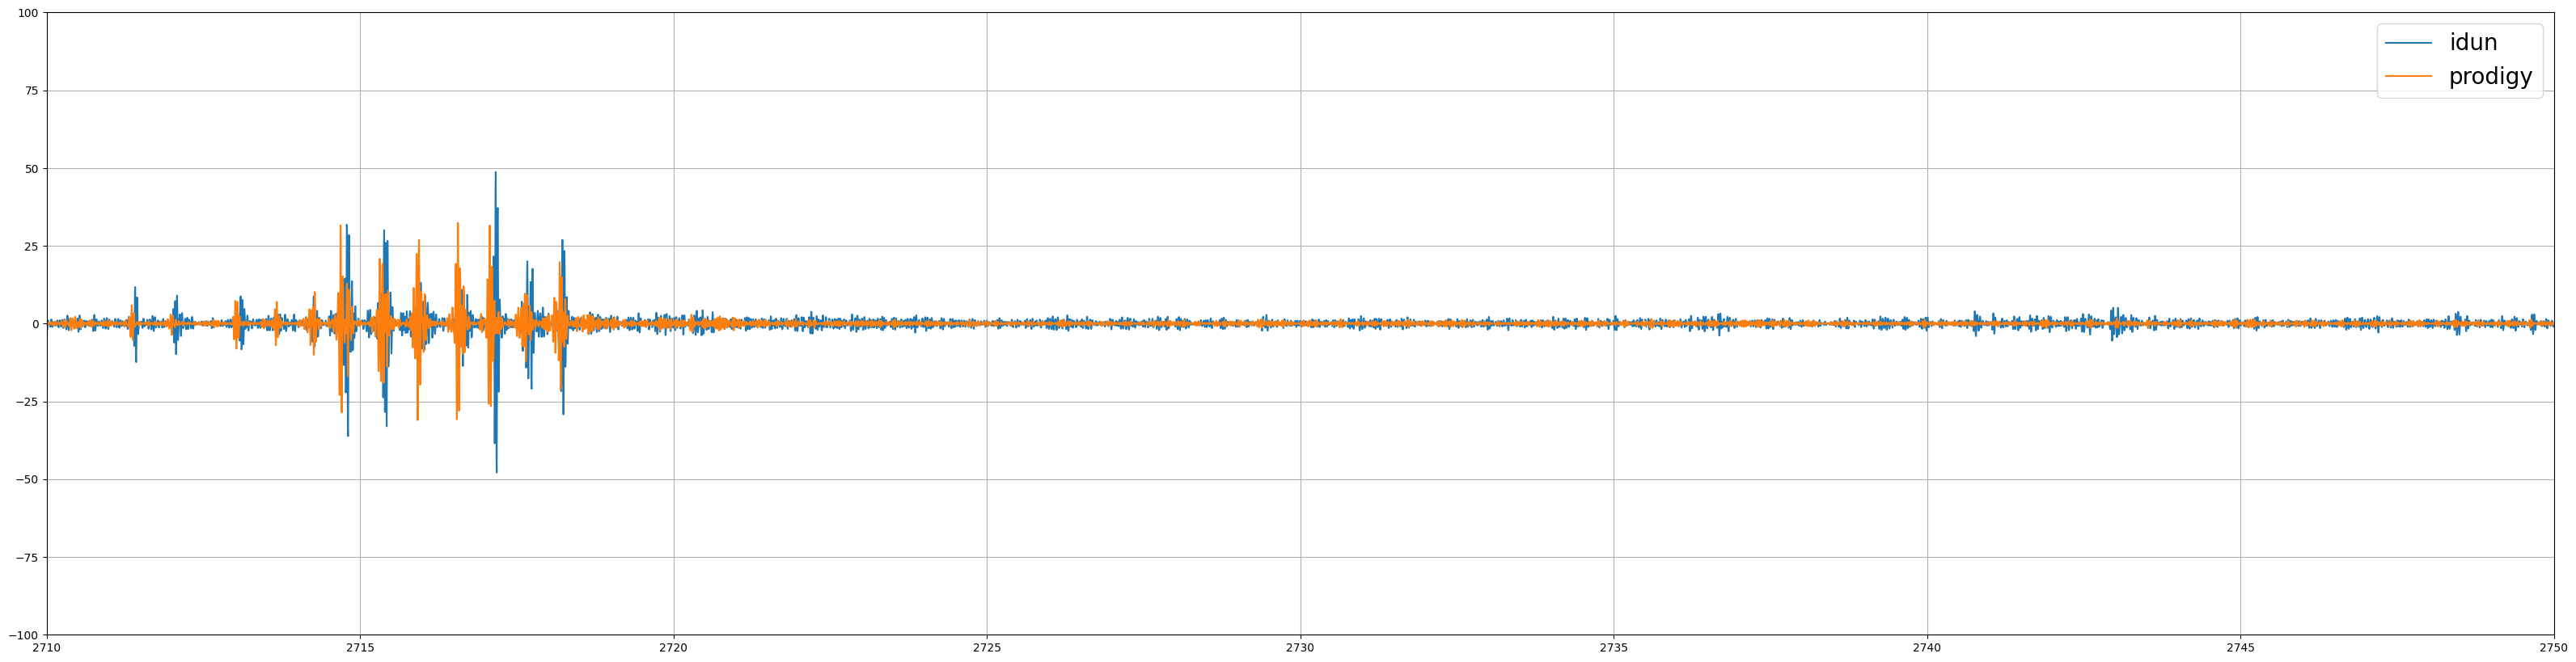

In [ ]:
plt.figure(figsize=(40, 10))
# create a seconds axis
shift = 0
time_seconds = np.arange(len(shifted_final_idun_arr))/BASE_SAMPLE_RATE
plt.plot(time_seconds,shifted_final_idun_arr, label='idun')
plt.plot(time_seconds,0.5*shifted_final_prodigy_arr, label='prodigy')
plt.legend(fontsize=20)
plt.xlim(2710, 2750)
plt.ylim(-100,100)
plt.grid()